Let's look step-by-step how we can generate these polygon backgrounds.

# Generating points

In [1]:
import numpy as np
from random import random
from math import floor
import matplotlib.pyplot as plt

In [2]:
def gen_grid(w, h, b_x, b_y, cell_size, variance, rand_fn):
    """ Calculates random 2d dot array

    Keyword Arguments:
    w         -- width of grid
    h         -- height of grid
    b_x       -- bleed in the x dimmension
    b_y       -- bleed in the y dimmension
    cell_size -- size of each triangle cell
    variance  -- variance in each placement
    rand_fn   -- function to generate random numbers
    """

    w = w + b_x
    h = h + b_y
    half_cell = cell_size * 0.5

    points = []
    cell_size = int(cell_size)
    for i in range(-b_x, w, cell_size):
        for j in range(-b_y, h, cell_size):
            x = floor((i + half_cell) + (rand_fn() * variance*2 - variance))
            y = floor((j + half_cell) + (rand_fn() * variance*2 - variance))
            points.append([int(x), int(y)])

    return np.array(points)

In [10]:
# Variables
graphWidth = 1920
graphHeight = 1080
bleedX = 200
bleedY = 200
cellSize = 190
variance = 50
randomFunction = random

In [11]:
samplePoints = gen_grid(graphWidth, graphHeight, bleedX, bleedY, cellSize, variance, randomFunction)

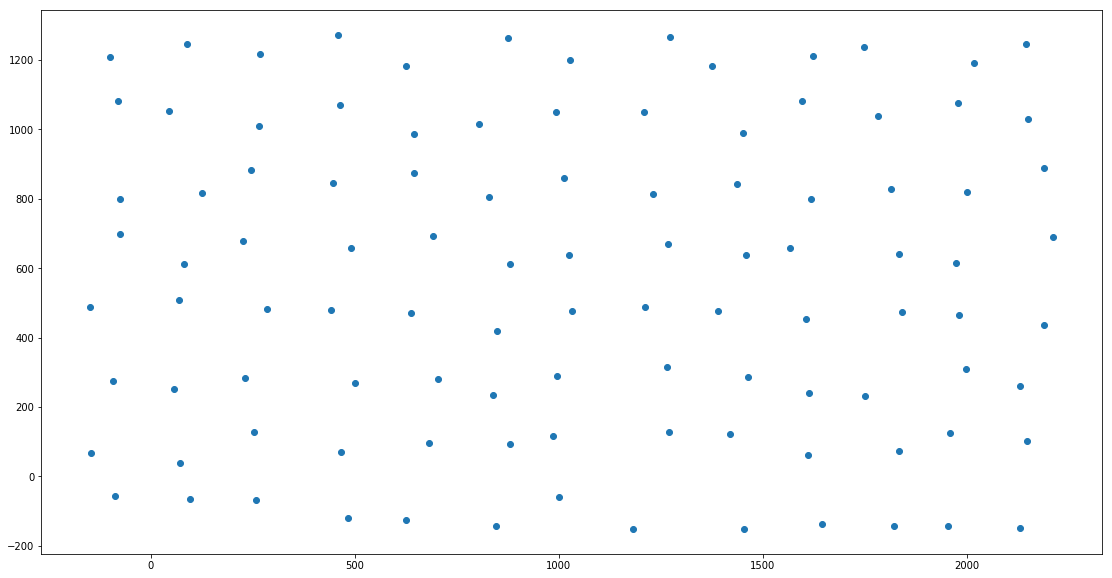

In [12]:
fig = plt.figure(figsize=(19,10))
plt.scatter(samplePoints[:,0], samplePoints[:,1])

In [6]:
from scipy.spatial import Delaunay
from skimage.draw import polygon

In [13]:
tri = Delaunay(samplePoints).simplices

In [14]:
tri

array([[ 99,  97,  96],
       [ 97,  99,  98],
       [ 96,  64,  56],
       [ 72,  80,  81],
       [ 80,  64,  96],
       [ 64,  80,  72],
       [101,  93, 100],
       [  1,   2,   3],
       [ 10,   2,   1],
       [ 14,  15,   7],
       [ 89,  97,  98],
       [ 73,  72,  81],
       [ 73,  64,  72],
       [102, 101, 103],
       [101, 102,  93],
       [ 63,  47,  55],
       [ 63,  87, 103],
       [ 47,  63,  31],
       [ 16,  24,  25],
       [ 33,  26,  25],
       [  6,  14,   7],
       [  6,   7,   3],
       [ 11,   4,   3],
       [ 11,  10,  18],
       [  2,  11,   3],
       [ 10,  11,   2],
       [ 23,  15,  14],
       [ 15,  23,  31],
       [ 93,  92, 100],
       [ 92,  99, 100],
       [ 99,  90,  98],
       [ 90,  89,  98],
       [ 80,  88,  81],
       [ 88,  89,  81],
       [ 88,  80,  96],
       [ 97,  88,  96],
       [ 89,  88,  97],
       [102,  94,  93],
       [ 17,  16,  25],
       [ 17,  26,  18],
       [ 26,  17,  25],
       [ 10,  17

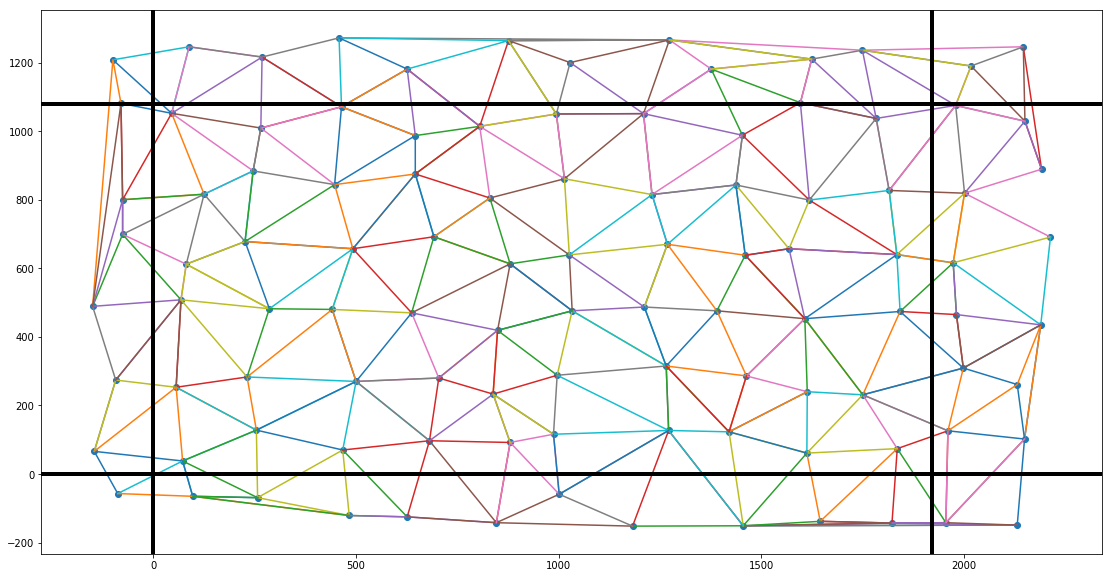

In [24]:
fig = plt.figure(figsize=(19,10))
for point in samplePoints[tri]:
        #print(tri)
        c = point[:, 0]
        r = point[:, 1]
        plt.plot(c,r)        
plt.scatter(samplePoints[:,0], samplePoints[:,1])

plt.axhline(y=0, color="black", linewidth=4)
plt.axvline(x=0, color="black", linewidth=4)
plt.axhline(y=graphHeight, color="black", linewidth=4)
plt.axvline(x=graphWidth, color="black", linewidth=4)

4091